In [37]:
import pandas as pd

donations = pd.read_csv('donations.csv')
essays = pd.read_csv('essays.csv')
outcomes = pd.read_csv('outcomes.csv')
projects = pd.read_csv('projects.csv')
resources = pd.read_csv('resources.csv')

## if running from colab
# from google.colab import drive
# drive.mount('/content/drive')
# donations = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/donations.csv')
# essays = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/essays.csv')
# outcomes = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/outcomes.csv')
# projects = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/projects.csv')
# resources = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/resources.csv')


In [38]:
# merge projects
df = projects.merge(outcomes[['projectid', 'fully_funded']], on='projectid', how='left')

# merge essays
df = df.merge(essays[['projectid', 'title', 'short_description', 'need_statement', 'essay']], on='projectid', how='left')

# Aggregate resources
resources_summary = resources.groupby('projectid').agg({
    'item_unit_price': ['sum', 'mean', 'max'],
    'item_quantity': ['sum', 'mean'],
    'project_resource_type': pd.Series.nunique
})
resources_summary.columns = [
    'resource_cost_sum', 'resource_price_avg', 'resource_price_max',
    'item_quantity_sum', 'item_quantity_avg', 'resource_type_count'
]
resources_summary = resources_summary.reset_index()
#merge resources
df = df.merge(resources_summary, on='projectid', how='left')

In [39]:
# aggregate donations
donations_agg = donations.groupby('projectid').agg({
    'donor_acctid': 'nunique',        
    'donationid': 'count'              
}).reset_index()

donations_agg = donations_agg.rename(columns={
    'donor_acctid': 'num_unique_donors',
    'donationid': 'donation_counts'
})

# 2. Merge donations
df = df.merge(donations_agg, on='projectid', how='left')

# Drop columns with too many missing values
missing_pct = df.isnull().mean().sort_values(ascending=False)
cols_to_drop = missing_pct[missing_pct > 0.4].index
df = df.drop(columns=cols_to_drop)

# Drop rows with missing labels
df = df.dropna(subset=['fully_funded'])


# Fill other NaNs with median
df = df.fillna({
    'students_reached': df['students_reached'].median(),
    'total_price_including_optional_support': df['total_price_including_optional_support'].median()
})

# text features 
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')
df['essay_length'] = df['essay'].astype(str).apply(len)
df['title_length'] = df['title'].astype(str).apply(len)
df['need_statement_length'] = df['need_statement'].astype(str).apply(len)
df['short_description_length'] = df['short_description'].astype(str).apply(len)

df['month_posted'] = df['date_posted'].dt.month
df['year_posted'] = df['date_posted'].dt.year
df['fully_funded_bin'] = df['fully_funded'].map({'t': 1, 'f': 0})


df = df[df['school_state'].isin(['NM','MI','UT','AZ','HI','CT','AA','WA','GA','OK','AE','CO','SC','TX'])]
df.to_csv('df.csv', index=False)
print(df.shape)
print(df.columns.tolist())
print(df['projectid'].is_unique)
df


(139377, 55)
['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_state', 'school_zip', 'school_metro', 'school_district', 'school_county', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_prefix', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'fulfillment_labor_materials', 'total_price_excluding_optional_support', 'total_price_including_optional_support', 'students_reached', 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'date_posted', 'fully_funded', 'title', 'short_description', 'need_statement', 'essay', 'resource_cost_sum', 'resource_price_avg', 'resource_price_max', 'item_quantity_sum', 'item_quantity_avg', 'resource_type_count', 'num_unique_donors', 'donati

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,resource_type_count,num_unique_donors,donation_counts,essay_length,title_length,need_statement_length,short_description_length,month_posted,year_posted,fully_funded_bin
44777,c685c844476d7ed75bf87699eeafd682,4b19500fb087a635c98061505f1e6c6f,34c650f9f6d5c3e42b8e2169c280ecb7,NaN,34.193630,-79.769058,Florence,SC,29501.0,urban,...,1.0,2.0,2.0,1118,47,93,197,12,2013,0
44784,3b6bddd1df0e310066d81c2b89771b5c,60a251a9fe882561405e9f6e135afb75,cf7b5a7b866094184208f0f4bc282e6a,3.500060e+11,35.130462,-106.514195,Albuquerque,NM,87111.0,urban,...,1.0,4.0,4.0,1047,26,50,199,12,2013,1
44786,301b1da14667351b130f88bfc2928825,9b8f56e9a0a7116e129760d21a252038,8b8981448286d07cddfaa1496262699b,4.013800e+10,33.427961,-112.600447,Buckeye,AZ,85326.0,NaN,...,1.0,NaN,NaN,1887,59,159,199,12,2013,0
44787,9470f32d62e450ce072fed930cda104f,d0dc57f1fc72b86b0d40f7be65a442f3,c244e679ba6992be565765c1b0c5a4d3,NaN,42.380127,-83.246609,Detroit,MI,48223.0,urban,...,1.0,NaN,NaN,1253,32,107,195,12,2013,0
44789,7174146d433b7726e69fdaf517352cfd,d5bf45e23c2694f6c16a0bc1650879ee,cfe5a7c6e546bb5e9666ee69aedff5a7,4.817700e+11,32.836391,-97.413704,Fort Worth,TX,76135.0,suburban,...,1.0,10.0,15.0,1951,20,166,196,12,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653211,f0cb62aa1fcef3c62e998b2fcad5e43f,cbaae1b8a03ce8e6fe173d4a90cb577f,630220a3621ddf46552b3b2d00f66f7e,4.503630e+11,34.959303,-82.015164,Spartanburg,SC,29301.0,suburban,...,1.0,1.0,1.0,1373,34,298,193,8,2005,1
653217,88a30b2c2e1b42eb31e30ea02d6ed153,cbaae1b8a03ce8e6fe173d4a90cb577f,630220a3621ddf46552b3b2d00f66f7e,4.503630e+11,34.959303,-82.015164,Spartanburg,SC,29301.0,suburban,...,1.0,2.0,2.0,1372,34,298,193,8,2005,1
653298,8f6665267478868f6dd860e592d3d72d,4f55ba48ce7ed7f6182f5dd7247fbe78,e6a710490206f33067abd27b4ea3087f,4.500720e+11,33.494147,-81.967933,North Augusta,SC,29841.0,suburban,...,1.0,NaN,NaN,880,13,156,192,8,2005,0
653312,d9286b631e524710333696f7d6891614,2f22a4f54d27d7c00ad8965cd364af07,de602401f9fa277bd3e3324fe98cf4b4,4.500900e+11,34.469060,-82.679843,Anderson,SC,29626.0,rural,...,1.0,NaN,NaN,1705,42,95,108,8,2005,0


In [40]:
print("Number of projects:", df.shape[0])
print("Columns:", df.shape[1])
print(df['fully_funded'].value_counts(normalize=True))


Number of projects: 139377
Columns: 55
fully_funded
t    0.670541
f    0.329459
Name: proportion, dtype: float64


In [41]:
print("Poverty level")
print(df['poverty_level'].value_counts())

print("\nGrade level")
print(df['grade_level'].value_counts())

print("\nSubject")
print(df['primary_focus_area'].value_counts())

print("\nStates")
print(df['school_state'].value_counts().head(10))


Poverty level
poverty_level
highest poverty     72324
high poverty        42605
moderate poverty    21588
low poverty          2860
Name: count, dtype: int64

Grade level
grade_level
Grades PreK-2    53590
Grades 3-5       46081
Grades 6-8       21700
Grades 9-12      18004
Name: count, dtype: int64

Subject
primary_focus_area
Literacy & Language    62727
Math & Science         36835
Music & The Arts       12099
Applied Learning       10342
Special Needs           7991
History & Civics        5882
Health & Sports         3492
Name: count, dtype: int64

States
school_state
TX    37200
SC    17587
OK    14101
GA    13736
MI    11019
WA     9714
AZ     8942
UT     8703
CT     7146
CO     6475
Name: count, dtype: int64


**Features**

In [ ]:

# features
all_feature_cols = [
    # These are the ones I had before
    'total_price_including_optional_support',
    'resource_cost_sum',
    'essay_length',
    'title_length',
    'need_statement_length',
    'poverty_level',
    'school_state',
    'students_reached',

    # These are the features we had for our merged_dataset. I dropped some columns such as 'projectid', 'teacher_acctid', 'schoolid', 'donor_acctid' since they don't 
    # help with our models. There are also a few columns that are in the merged_dataset but i didn't find them: 
    # ['at_least_1_teacher_referred_donor', 'at_least_1_green_donation', 'great_chat', 'three_or_more_non_teacher_referred_donors', 
    # 'one_non_teacher_referred_donor_giving_100_plus', 'donation_from_thoughtful_donor', 'great_messages_proportion', 'teacher_referred_count', 
    # 'non_teacher_referred_count']
    'resource_type',
    'item_quantity_sum',      
    'donation_counts',
]

# Drop rows with missing required values
df_model = df[all_feature_cols + ['fully_funded_bin']].dropna()

# Define X and y
X = df_model[all_feature_cols]
y = df_model['fully_funded_bin']

df_model.to_csv('feature_matrix.csv', index=False)

print(df_model.shape)
df_model.to_csv('feature_matrix.csv', index=False)
df_model


(115918, 12)
fully_funded_bin
1    0.805966
0    0.194034
Name: proportion, dtype: float64


,total_price_including_optional_support,resource_cost_sum,essay_length,title_length,need_statement_length,poverty_level,school_state,students_reached,resource_type,item_quantity_sum,donation_counts,fully_funded_bin
44777,809.54,204.00,1118,47,93,high poverty,SC,22.0,Supplies,27.0,2.0,0
44784,610.62,469.98,1047,26,50,highest poverty,NM,160.0,Technology,2.0,4.0,1
44789,937.85,137.61,1951,20,166,high poverty,TX,24.0,Technology,5.0,15.0,1
44791,430.22,299.99,2362,21,86,highest poverty,CO,19.0,Technology,1.0,8.0,1
44801,511.64,313.25,1784,16,126,moderate poverty,AZ,15.0,Supplies,19.0,19.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
653144,1962.50,118.38,1305,44,276,moderate poverty,SC,20.0,Books,204.0,1.0,0
653157,2148.76,1547.69,1537,19,73,highest poverty,SC,40.0,Technology,3.0,1.0,1
653195,436.59,32.50,1247,68,132,moderate poverty,SC,225.0,Supplies,10.0,1.0,1
653211,1352.50,484.00,1373,34,298,high poverty,SC,400.0,Supplies,2.0,1.0,1


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder


In [53]:
# One hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['resource_type', 'poverty_level', 'school_state'], drop_first=True)

from sklearn.preprocessing import StandardScaler
# Scale numeric features
numeric_cols = [
    'total_price_including_optional_support',
    'resource_cost_sum',
    'essay_length',
    'title_length',
    'need_statement_length',
    'students_reached',
]
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

In [54]:
# split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)


In [55]:
print("Feature matrix shape:", X_encoded.shape)
print("distribution:\n", y.value_counts(normalize=True))

Feature matrix shape: (115918, 27)
distribution:
 fully_funded_bin
1    0.805966
0    0.194034
Name: proportion, dtype: float64


In [56]:
# ==================== MODELS ====================
lr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42).fit(X_train, y_train)
sgd = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

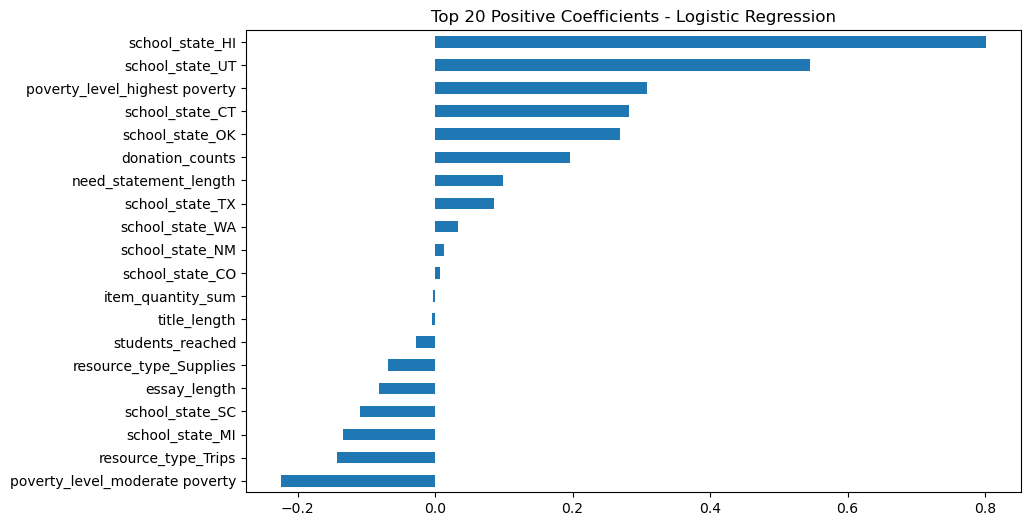

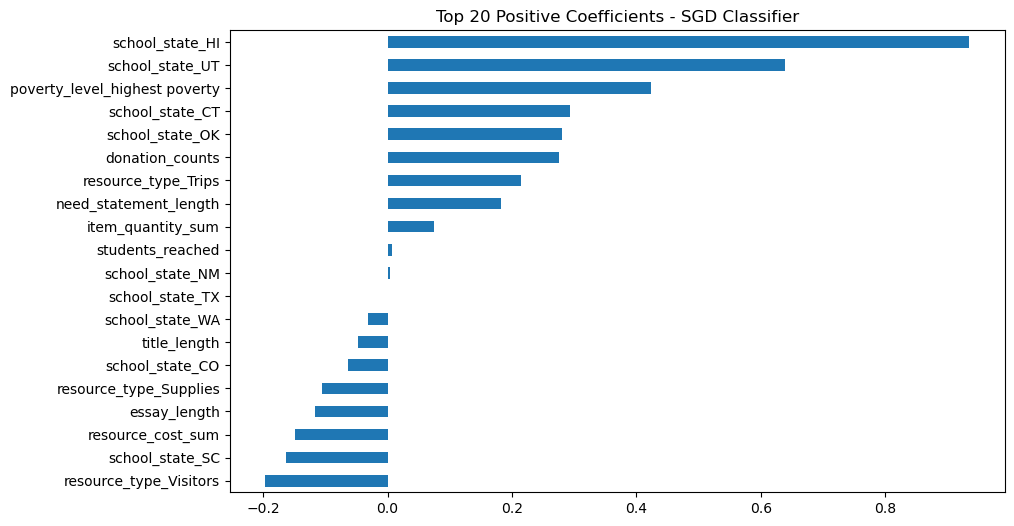

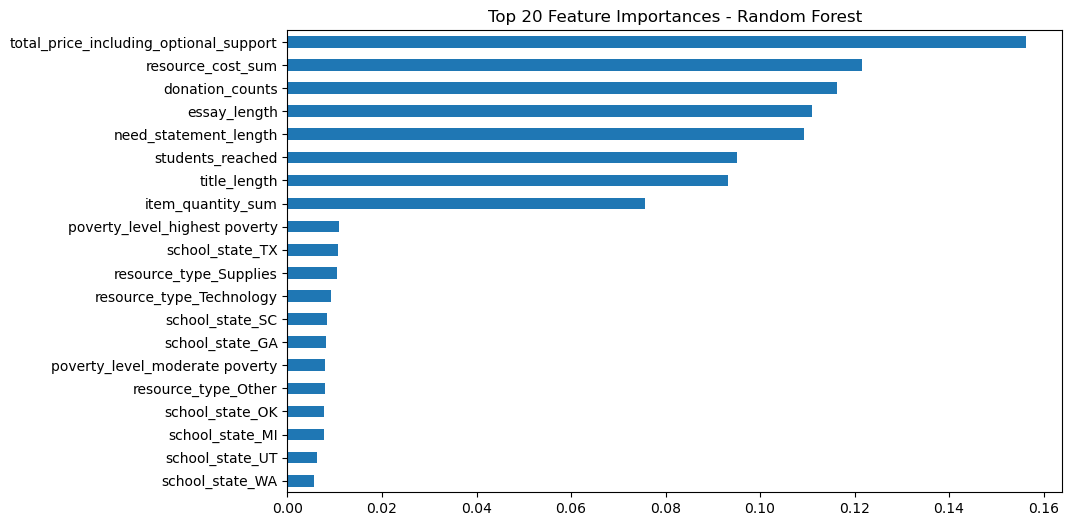

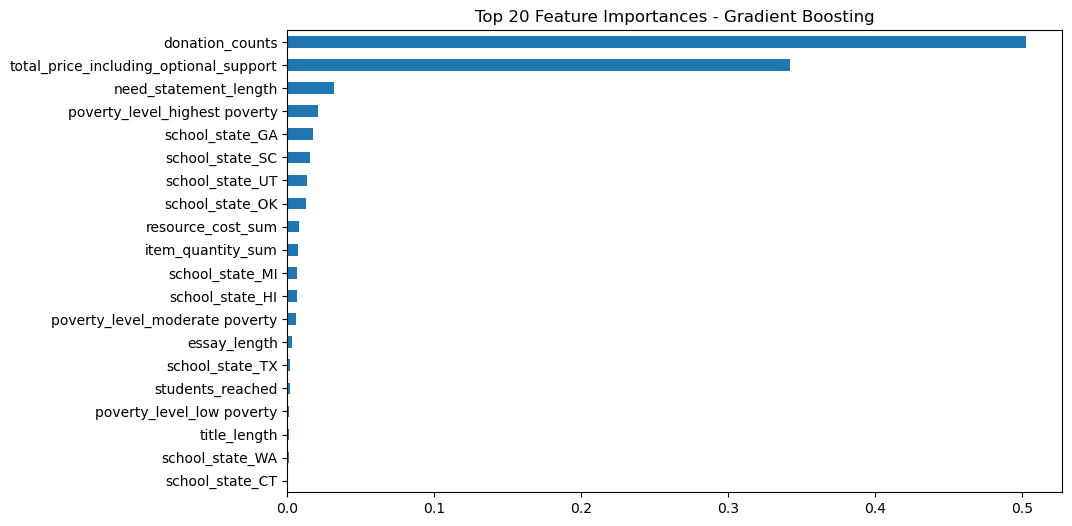

In [57]:
# ==================== FEATURE IMPORTANCE ====================
# Logistic Regression
lr_importance = pd.DataFrame(lr.coef_[0], index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
lr_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Positive Coefficients - Logistic Regression")
plt.show()

# SGD
sgd_importance = pd.DataFrame(sgd.coef_[0], index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
sgd_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Positive Coefficients - SGD Classifier")
plt.show()

# Random Forest
rf_importance = pd.DataFrame(rf.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
rf_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - Random Forest")
plt.show()

# Gradient Boosting
gb_importance = pd.DataFrame(gb.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
gb_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - Gradient Boosting")
plt.show()

## Feature Importance Highlights

### 1. Logistic Regression
- **Most positively associated with success:**
  - `school_state_HI`, `school_state_NH`, `school_state_DC`
  - `poverty_level_highest poverty`
- Strong presence of **school_state** dummy variables shows that **geographic location** has high predictive power in linear separation.
- Also, `need_statement_length` appears to be relevant.

---

### 2. SGD Classifier
- Similar to Logistic Regression, but with **`resource_cost_sum`** as the top coefficient.
- High variance in coefficients (e.g., 1.2 for resource cost), possibly due to **regularization differences**.
- **State features** and `need_statement_length` are again **prominent**.

---

### 3. Random Forest
- **Top features:**
  - `total_price_including_optional_support`
  - `resource_cost_sum`
  - `essay_length`, `need_statement_length`, `students_reached`
- Tree-based models focus more on **numeric and continuous features**.
- **School states** and **poverty level dummies** rank lower — likely due to less consistent impact across decision splits.

---

### 4. Gradient Boosting
- **Dominated by**: `total_price_including_optional_support` (massively high importance)
- Next most important:
  - `need_statement_length`
  - `poverty_level_highest poverty`
  - A few `school_state` variables
- Suggests that **cost** and **poverty severity** are especially powerful when boosting decision trees.


 ## So I think include Poverty Level, essay/need statement length, cost features. Don't include state, or focus on specific state.



In [58]:
# Get predicted probability of being funded (1 = funded)
full_probs = gb.predict_proba(X_encoded)[:, 1]

# Attach predictions to your original model dataframe
df_model['predicted_prob'] = full_probs
df_model['projectid'] = df.loc[df_model.index, 'projectid']  # attach project ID back

# Sort by lowest predicted probability (least likely to be funded)
df_ranked = df_model.sort_values(by='predicted_prob', ascending=True)

# Select bottom 10%
cutoff = int(len(df_ranked) * 0.10)
bottom_10 = df_ranked.head(cutoff)


bottom_10[['projectid', 'predicted_prob']].to_csv('projects_for_expert_review.csv', index=False)
print(bottom_10[['projectid', 'predicted_prob']].head(10))


                               projectid  predicted_prob
592106  777241968c056f7b4f2c90d0463dd7a9        0.184981
618646  9c529ea393950448c26f35db03df78c5        0.192182
618378  16cb8ed9f75cd6a0b348acd82803fe9b        0.192231
618241  ff2e6e8c8fe9e58e1f91666ff39c06ab        0.197673
627924  19117936de379da0325d60548697aa0a        0.200883
625211  fdd1681e70439299bf33a79cb92c7de4        0.206396
617469  abedf832b799c69d643dad2391d78d85        0.206403
644693  c4a5294450714026e62d79481e0eb34f        0.207584
647884  94d6c4e8ab849ea9cae0c468372dfcec        0.218324
617528  7814ee92e3c20dbc7d953a8020571ab9        0.218377


In [62]:
# ==================== EVALUATION ====================
y_probs = {
    'Logistic Regression': lr.predict_proba(X_test)[:, 1],
    'Random Forest': rf.predict_proba(X_test)[:, 1],
    'Gradient Boosting': gb.predict_proba(X_test)[:, 1],
    'SGD Classifier': sgd.predict_proba(X_test)[:, 1],
    'KNN': knn.predict_proba(X_test)[:, 1],
}

results = pd.DataFrame({
    'Model': list(y_probs.keys()),
    'ROC AUC': [roc_auc_score(y_test, prob) for prob in y_probs.values()]
})
print(results)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

for model_name, y_prob in y_probs.items():
    y_pred = (y_prob >= 0.5).astype(int)
    print(f"\n{model_name} Classification Report (focus on not-funded projects):")
    print(classification_report(y_test, y_pred, target_names=['Not Funded', 'Funded']))

    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)

    print(f"Precision (Not Funded): {precision:.3f}")
    print(f"Recall (Not Funded): {recall:.3f}")
    print(f"F1 Score (Not Funded): {f1:.3f}")





                 Model   ROC AUC
0  Logistic Regression  0.751683
1        Random Forest  0.800028
2    Gradient Boosting  0.802482
3       SGD Classifier  0.673286
4                  KNN  0.671107

Logistic Regression Classification Report (focus on not-funded projects):
              precision    recall  f1-score   support

  Not Funded       0.44      0.04      0.07      4498
      Funded       0.81      0.99      0.89     18686

    accuracy                           0.80     23184
   macro avg       0.62      0.51      0.48     23184
weighted avg       0.74      0.80      0.73     23184

Precision (Not Funded): 0.436
Recall (Not Funded): 0.037
F1 Score (Not Funded): 0.068

Random Forest Classification Report (focus on not-funded projects):
              precision    recall  f1-score   support

  Not Funded       0.59      0.19      0.28      4498
      Funded       0.83      0.97      0.89     18686

    accuracy                           0.82     23184
   macro avg       0.71    

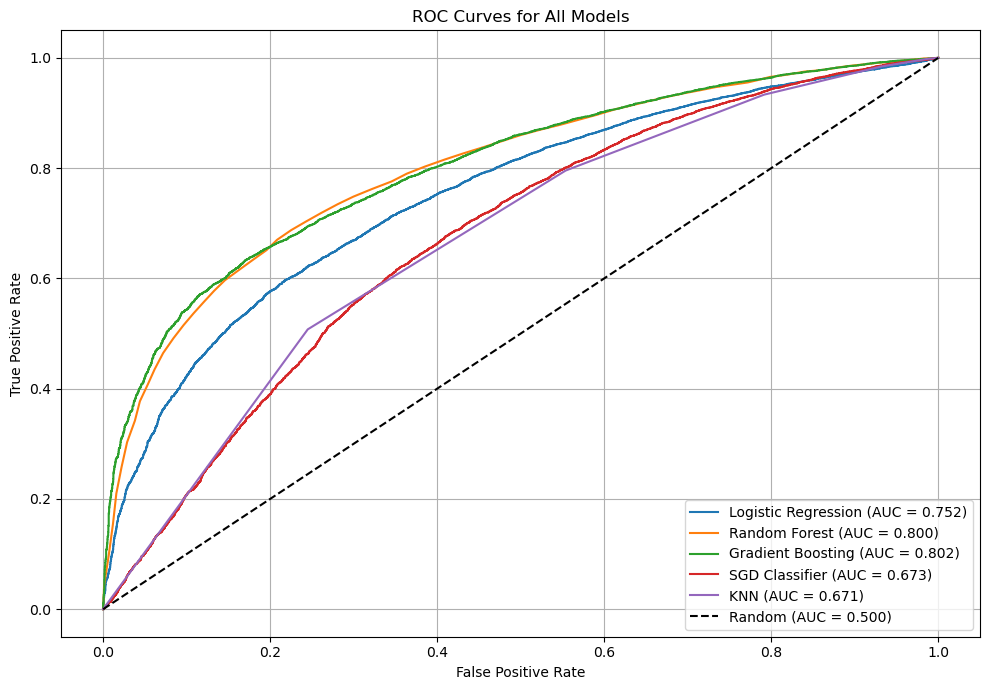

In [63]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 7))

for model_name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Get predicted labels (using default threshold = 0.5)
y_preds = {
    'Logistic Regression': lr.predict(X_test),
    'Random Forest': rf.predict(X_test),
    'Gradient Boosting': gb.predict(X_test),
    'SGD Classifier': sgd.predict(X_test),
    'KNN': knn.predict(X_test),
}

metrics = []

for model_name, y_pred in y_preds.items():
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc_score(y_test, y_probs[model_name])
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df.sort_values(by='F1-score', ascending=False))


                 Model  Precision    Recall  F1-score       AUC
2    Gradient Boosting   0.824787  0.978701  0.895176  0.802482
1        Random Forest   0.833988  0.965429  0.894908  0.800028
3       SGD Classifier   0.812234  0.991277  0.892868  0.673286
0  Logistic Regression   0.810025  0.988494  0.890405  0.751683
4                  KNN   0.830476  0.933319  0.878899  0.671107


---